In [1]:
# Change the path if necessary
datasets_path = 'datasets'

import sys
import os

# Deploy AML code in colab
if 'google.colab' in sys.modules:
    if not os.path.exists('/content/applied-ml/'):
        !wget -q https://raw.githubusercontent.com/tsunrise/colab-github/main/colab_github.py
        import colab_github
        colab_github.github_auth(persistent_key=False)

        %cd /content/
        !git clone git@github.com:oz-e/applied-ml.git
        if not os.path.exists('/content/applied-ml/'):
            raise Exception('Please follow the instructions to add the SSH key to your account in order to clone private repo')

    %cd /content/applied-ml/

    # Install any other requirements (to be converted to requirements.txt)
    !pip install openai-clip

In [2]:
import os

if not os.path.exists('CuPL'):
    !git clone https://github.com/sarahpratt/CuPL.git

In [3]:
import numpy as np
import torch
import clip
import json
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from CuPL.imagenet_prompts.standard_image_prompts import imagenet_templates

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
model, preprocess = clip.load('ViT-B/16', device=device, jit=False)

In [6]:
import aml.datasets

dataset_test = aml.datasets.DTD(datasets_path, split='test')

In [7]:
cls_names_sorted = [dataset_test.lab2cname[label_id] for label_id in sorted(dataset_test.lab2cname.keys())]

In [8]:
# Create class name features
with torch.no_grad():
    cls_name_label_ids = np.arange(len(cls_names_sorted))
    cls_name_features_cuda = model.encode_text(clip.tokenize(cls_names_sorted).to(device))
    cls_name_features_cuda /= cls_name_features_cuda.norm(dim=-1, keepdim=True)
    cls_name_features = cls_name_features_cuda.cpu().numpy()

    # Fill diagonal for better visibility
    cls_name_masked_similarity = (cls_name_features_cuda @ cls_name_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

In [9]:
def calc_features(encoder, items_dict):
    with torch.no_grad():
        label_ids = []
        features_cuda = []
        cls_features_cuda = []
        for label_id in tqdm(range(len(cls_names_sorted))):
            items = items_dict.pop(label_id)
            label_ids.append([label_id] * len(items))
            class_embeddings = encoder(items)
            class_embeddings /= class_embeddings.norm(dim=-1, keepdim=True)
            class_embedding = class_embeddings.mean(dim=0)
            class_embedding /= class_embedding.norm()
            features_cuda.append(class_embeddings)
            cls_features_cuda.append(class_embedding)
        label_ids = np.hstack(label_ids)
        features = torch.vstack(features_cuda).cpu().numpy()
        cls_features_cuda = torch.vstack(cls_features_cuda)

        # Fill diagonal for better visibility
        masked_similarity = (cls_features_cuda @ cls_features_cuda.T).fill_diagonal_(float('nan')).cpu().numpy()

    return label_ids, features, features_cuda, cls_features_cuda, masked_similarity

In [10]:
def encode_text(texts):
    with torch.no_grad():
        return model.encode_text(clip.tokenize(texts).to(device))

In [11]:
# Create template text features
template_label_texts_list = {label_id: [template.format(cls_name) for template in imagenet_templates] for label_id, cls_name in enumerate(cls_names_sorted)}
template_label_ids, template_text_features, template_text_features_cuda, template_cls_features_cuda, template_masked_similarity = calc_features(encode_text, template_label_texts_list)

100%|██████████| 47/47 [00:00<00:00, 47.44it/s]


In [12]:
PATH_TO_PROMPTS = './CuPL/all_prompts/full_prompts/texture_prompts_full.json'

with open(PATH_TO_PROMPTS) as f:
    gpt3_prompts_file = json.load(f)

In [13]:
# Mapping between CuPL and cls_name
special_class_mapping = {
}

# Synonyms for excluding the filtering of the CuPL prompts
special_synonyms = {
    'meshed': ['mesh'],
    'stratified': ['strata'],
    'swirly': ['swirl'],
    'pleated': ['pleat', 'pleating'],
    'flecked': ['fleck'],
    'stained': ['stain'],
    'porous': ['pore'],
    'banded': ['banding'],
    'lacelike': ['lace'],
    'sprinkled': ['sprinkling'],
    'veined': ['vein'],
    'potholed': ['pothole'],
    'spiralled': ['spiraled', 'spiral'],
    'grooved': ['groove'],
    'crosshatched': ['crosshatch', 'crosshatching'],
    'wrinkled': ['wrinkle'],
    'smeared': ['smear'],
    'striped': ['strip', 'stripe'],
    'braided': ['braid'],
    'freckled': ['freckle'],
    'cobwebbed': ['cobweb'],
    'honeycombed': ['honeycomb'],
    'zigzagged': ['zigzag'],
    'marbled': ['marbling'],
}

In [14]:
import re
import inflect
p = inflect.engine()

# Lookup CuLP prompts from cls_name
original_gpt3_prompts = {}
filtered_gpt3_prompts = {}

for gpt3_cls_name, texts in gpt3_prompts_file.items():
    cls_name = special_class_mapping.get(gpt3_cls_name, gpt3_cls_name).replace(' ', '_')
    if cls_name not in dataset_test.classnames:
        continue
    original_gpt3_prompts[cls_name] = texts

    # Filter out texts that does not contain the class name
    synonyms_list = special_synonyms.get(gpt3_cls_name, [])
    cls_name_set = set(
        gpt3_cls_name.lower().replace('-', ' ').split() +
        p.plural(gpt3_cls_name).lower().replace('-', ' ').split() +
        gpt3_cls_name.lower().replace('-', ' ').replace(' ', '').split() +
        synonyms_list +
        [p.plural(syn).lower() for syn in synonyms_list]
    )
    filtered_gpt3_prompts[cls_name] = [text for text in texts if not cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    filtered = [text for text in texts if cls_name_set.isdisjoint(re.findall(r'\b\w+\b|[^\w\s]', text.lower()))]
    if len(filtered) != 0:
        print(f'Filtered {len(filtered)} prompts for ({dataset_test.classnames.index(cls_name)}){cls_name}')
        print(filtered)
        print()

Filtered 1 prompts for (25)meshed
['Meshing is a process of breaking down a 3D object into a network of triangles.']

Filtered 1 prompts for (7)cracked
['A broken surface has an irregular, jagged shape.']

Filtered 4 prompts for (38)stratified
['Stone that has been split into thin, parallel layers.', 'There is no definitive answer to this question because it can depend on the specific rock being observed.', 'A statified object is one that has been divided into layers, often of different materials.', 'There is no definitive answer to this question since stratification can occur in many different ways and produce a wide variety of patterns.']

Filtered 1 prompts for (33)scaly
['A scale is a thin plate of material, such as an icicle, that is attached to a surface.']

Filtered 5 prompts for (41)swirly
['There is no definitive answer to this question since it is open to interpretation.', "I'm not sure what you mean.", 'I cannot answer this question with any certainty.', "I'm not sure what y

In [15]:
# Create original gpt3 text features
original_gpt3_label_texts_list = {label_id: original_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
original_gpt3_label_ids, original_gpt3_text_features, original_gpt3_text_features_cuda, original_gpt3_cls_features_cuda, original_gpt3_masked_similarity = calc_features(encode_text, original_gpt3_label_texts_list)
# Create filtered gpt3 text features
filtered_gpt3_label_texts_list = {label_id: filtered_gpt3_prompts[cls_name] for label_id, cls_name in enumerate(cls_names_sorted)}
filtered_gpt3_label_ids, filtered_gpt3_text_features, filtered_gpt3_text_features_cuda, filtered_gpt3_cls_features_cuda, filtered_gpt3_masked_similarity = calc_features(encode_text, filtered_gpt3_label_texts_list)

100%|██████████| 47/47 [00:00<00:00, 66.96it/s]


In [16]:
def encode_images(imgs):
    with torch.no_grad():
        return model.encode_image(torch.stack([preprocess(img) for img in imgs]).to(device))

In [17]:
# Create image features
imgs_grouped = defaultdict(list)
for img, label_id in dataset_test:
    imgs_grouped[label_id].append(img)
img_label_ids, _, img_features_cuda, _, img_masked_similarity = calc_features(encode_images, imgs_grouped)

100%|██████████| 47/47 [00:16<00:00,  2.84it/s]


In [18]:
import sklearn.metrics

def calc_clip_pred(label_ids, img_features_cuda, text_features_cuda):
    with torch.no_grad():
        if type(text_features_cuda) == list:  # list of tensors
            logits = torch.vstack([(img_features_cuda @ embeddings.T).mean(dim=-1) for embeddings in text_features_cuda]).T
        else:
            logits = img_features_cuda @ text_features_cuda.T
        pred = logits.argmax(dim=-1).cpu().numpy()

        return (pred == label_ids).mean(), sklearn.metrics.confusion_matrix(label_ids, pred, labels=np.arange(len(cls_names_sorted)), normalize='true')

In [19]:
# Combine template text with gpt3 text features
combined_original_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, original_gpt3_text_features_cuda)]
combined_filtered_gpt3_text_features_cuda = [torch.vstack((text_features1, text_features2)) for text_features1, text_features2 in zip(template_text_features_cuda, filtered_gpt3_text_features_cuda)]
combined_original_gpt3_cls_features_cuda = []
combined_filtered_gpt3_cls_features_cuda = []
for class_embeddings in combined_original_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_original_gpt3_cls_features_cuda.append(class_embedding)
for class_embeddings in combined_filtered_gpt3_text_features_cuda:
    class_embedding = class_embeddings.mean(dim=0)
    class_embedding /= class_embedding.norm()
    combined_filtered_gpt3_cls_features_cuda.append(class_embedding)
combined_original_gpt3_cls_features_cuda = torch.vstack(combined_original_gpt3_cls_features_cuda)
combined_filtered_gpt3_cls_features_cuda = torch.vstack(combined_filtered_gpt3_cls_features_cuda)

In [20]:
# Zero-shot classification of CLIP
img_features_stacked_cuda = torch.vstack(img_features_cuda)

cls_name_acc, cls_name_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, cls_name_features_cuda)
template_cls_acc, template_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_cls_features_cuda)
template_text_acc, template_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, template_text_features_cuda)
original_gpt3_cls_acc, original_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_cls_features_cuda)
original_gpt3_text_acc, original_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, original_gpt3_text_features_cuda)
filtered_gpt3_cls_acc, filtered_gpt3_cls_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_cls_features_cuda)
filtered_gpt3_text_acc, filtered_gpt3_text_cm = calc_clip_pred(img_label_ids, img_features_stacked_cuda, filtered_gpt3_text_features_cuda)
combined_original_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_cls_features_cuda)
combined_original_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_original_gpt3_text_features_cuda)
combined_filtered_gpt3_cls_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_cls_features_cuda)
combined_filtered_gpt3_text_acc, _ = calc_clip_pred(img_label_ids, img_features_stacked_cuda, combined_filtered_gpt3_text_features_cuda)

In [21]:
print(f'Accuracy of CLIP with class names: {cls_name_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (centroid): {template_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with text template (individual avg): {template_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (centroid): {original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with original GPT-3 text (individual avg): {original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (centroid): {filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with filtered GPT-3 text (individual avg): {filtered_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (centroid): {combined_original_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined original GPT-3 text (individual avg): {combined_original_gpt3_text_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (centroid): {combined_filtered_gpt3_cls_acc*100:.2f}%')
print(f'Accuracy of CLIP with combined filtered GPT-3 text (individual avg): {combined_filtered_gpt3_text_acc*100:.2f}%')

Accuracy of CLIP with class names: 45.80%
Accuracy of CLIP with text template (centroid): 45.27%
Accuracy of CLIP with text template (individual avg): 45.69%
Accuracy of CLIP with original GPT-3 text (centroid): 53.96%
Accuracy of CLIP with original GPT-3 text (individual avg): 52.54%
Accuracy of CLIP with filtered GPT-3 text (centroid): 53.72%
Accuracy of CLIP with filtered GPT-3 text (individual avg): 52.54%
Accuracy of CLIP with combined original GPT-3 text (centroid): 48.23%
Accuracy of CLIP with combined original GPT-3 text (individual avg): 49.23%
Accuracy of CLIP with combined filtered GPT-3 text (centroid): 48.17%
Accuracy of CLIP with combined filtered GPT-3 text (individual avg): 49.41%


In [22]:
# Zero-shot classification of CLIP using one text on all images
template_text_individual_features_cuda = list(torch.stack(template_text_features_cuda).permute(1, 0, 2))
template_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in template_text_individual_features_cuda])
original_gpt3_text_individual_features_cuda = list(torch.stack(original_gpt3_text_features_cuda).permute(1, 0, 2))
original_gpt3_text_individual_acc = np.array([calc_clip_pred(img_label_ids, img_features_stacked_cuda, text_features_cuda)[0] for text_features_cuda in original_gpt3_text_individual_features_cuda])

In [23]:
print(f'Accuracy of CLIP with text template (one text on all images): mean={template_text_individual_acc.mean()*100:.2f}%, std={template_text_individual_acc.std()}')
print(f'Accuracy of CLIP with original GPT-3 text (one text on all images): mean={original_gpt3_text_individual_acc.mean()*100:.2f}%, std={original_gpt3_text_individual_acc.std()}')

Accuracy of CLIP with text template (one text on all images): mean=42.24%, std=0.02394437281016734
Accuracy of CLIP with original GPT-3 text (one text on all images): mean=40.83%, std=0.021426781742907828


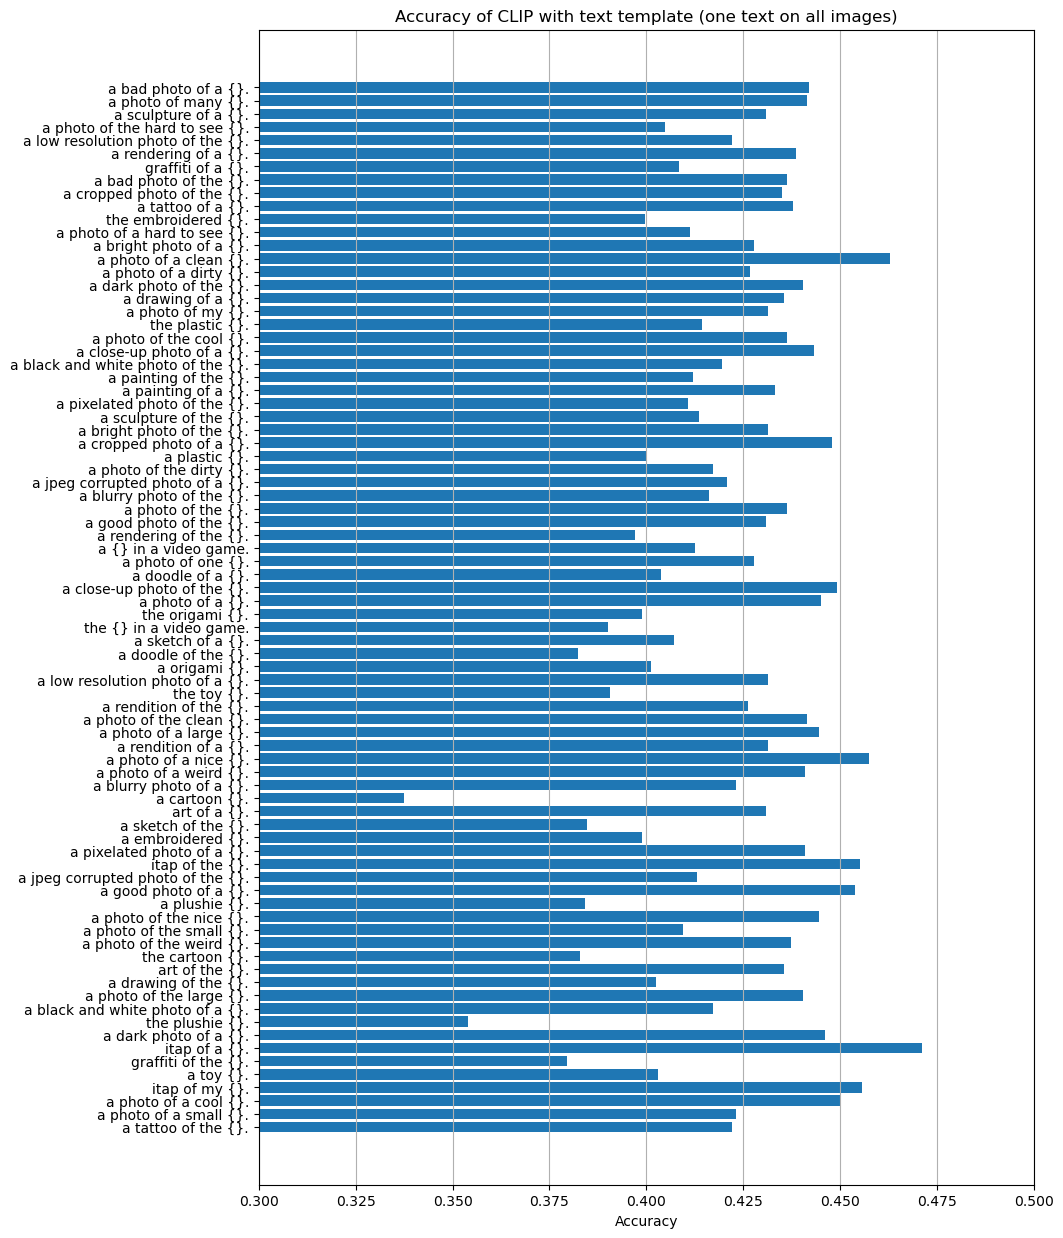

In [24]:
plt.figure(figsize=(10, 15))
plt.barh(np.arange(len(template_text_individual_acc)), template_text_individual_acc, align='center')
plt.yticks(np.arange(len(template_text_individual_acc)), imagenet_templates)
plt.xlabel('Accuracy')
plt.title('Accuracy of CLIP with text template (one text on all images)')
scale = 0.05
plt.xlim(int(template_text_individual_acc.min()/scale)*scale, (int(template_text_individual_acc.max()/scale)+1)*scale)
plt.grid(axis='x')
plt.gca().invert_yaxis()
plt.show()

In [25]:
def calc_features_similarity(features1_cuda, features2_cuda):
    with torch.no_grad():
        similarity_cuda = []
        for embeddings1 in features1_cuda:
            if type(features2_cuda) == list:  # list of tensors
                similarity_cuda.append(torch.Tensor([(embeddings1 @ embeddings2.T).mean() for embeddings2 in features2_cuda]))
            else:
                similarity_cuda.append((embeddings1 @ features2_cuda.T).mean(dim=0))

        return torch.vstack(similarity_cuda).cpu().numpy()

In [26]:
# Calculate similarity between image features and text features
img_cls_name_similarity = calc_features_similarity(img_features_cuda, cls_name_features_cuda)
img_template_cls_similarity = calc_features_similarity(img_features_cuda, template_cls_features_cuda)
img_template_text_similarity = calc_features_similarity(img_features_cuda, template_text_features_cuda)
img_original_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, original_gpt3_cls_features_cuda)
img_original_gpt3_text_similarity = calc_features_similarity(img_features_cuda, original_gpt3_text_features_cuda)
img_filtered_gpt3_cls_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_cls_features_cuda)
img_filtered_gpt3_text_similarity = calc_features_similarity(img_features_cuda, filtered_gpt3_text_features_cuda)

In [27]:
def print_top_pairs(similarity, text, top=10):
    # Get the indices of top values
    top_indices = np.unravel_index(np.argsort(-similarity, axis=None)[:top], similarity.shape)

    # Extract the class names and labels for top values
    for idx, (label1, label2) in enumerate(zip(*top_indices)):
        print(f'Rank {idx+1}: ({label1}){cls_names_sorted[label1]} - ({label2}){cls_names_sorted[label2]}, {text}: {similarity[label1, label2]}')

In [28]:
def plot_similarity(similarity, title, xlabel=None, ylabel=None):
    plt.figure(figsize=(12, 10))
    plt.imshow(similarity)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [29]:
def plot_cm(cm, title):
    plt.figure(figsize=(12, 10))
    plt.imshow(cm)
    plt.xticks(np.arange(0, len(cls_names_sorted), 5))
    plt.yticks(np.arange(0, len(cls_names_sorted), 5))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [30]:
def visualize_auto_similarity(masked_similarity, title):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.nanstd(masked_similarity)}')
    print_top_pairs(np.triu(masked_similarity, k=1), 'similarity')
    plot_similarity(masked_similarity, title_similarity)

In [31]:
def visualize_cross_similarity(similarity, cm, title, xlabel='Text', ylabel='Image'):
    title_similarity = title + ' Similarity'
    print(f'{title_similarity.capitalize()} mean: {np.mean(similarity)}')
    print(f'{title_similarity.capitalize()} std: {np.std(similarity)}')
    diagonal_similarity = similarity.diagonal()
    print(f'{title_similarity.capitalize()} diagonal mean: {np.mean(diagonal_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal std: {np.std(diagonal_similarity)}')
    masked_similarity = similarity.copy()
    np.fill_diagonal(masked_similarity, np.nan)
    print(f'{title_similarity.capitalize()} non-diagonal mean: {np.nanmean(masked_similarity)}')
    print(f'{title_similarity.capitalize()} non-diagonal std: {np.nanstd(masked_similarity)}')
    print(f'{title_similarity.capitalize()} diagonal mean to non-diagonal mean ratio: {np.mean(diagonal_similarity)/np.nanmean(masked_similarity)}')
    print_top_pairs(masked_similarity, 'similarity', top=20)
    plot_similarity(similarity, title_similarity, xlabel=xlabel, ylabel=ylabel)
    masked_cm = cm.copy()
    np.fill_diagonal(masked_cm, np.nan)
    print_top_pairs(masked_cm, 'error rate', top=20)
    plot_cm(cm, title + ' Confusion Matrix')

Class name similarity mean: 0.7919921875
Class name similarity std: 0.04669189453125
Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.91162109375
Rank 2: (20)knitted - (44)woven, similarity: 0.90771484375
Rank 3: (19)interlaced - (35)spiralled, similarity: 0.90185546875
Rank 4: (1)blotchy - (12)flecked, similarity: 0.900390625
Rank 5: (19)interlaced - (38)stratified, similarity: 0.89697265625
Rank 6: (35)spiralled - (41)swirly, similarity: 0.89697265625
Rank 7: (35)spiralled - (38)stratified, similarity: 0.89306640625
Rank 8: (31)porous - (32)potholed, similarity: 0.89208984375
Rank 9: (25)meshed - (44)woven, similarity: 0.89013671875
Rank 10: (7)cracked - (12)flecked, similarity: 0.8876953125


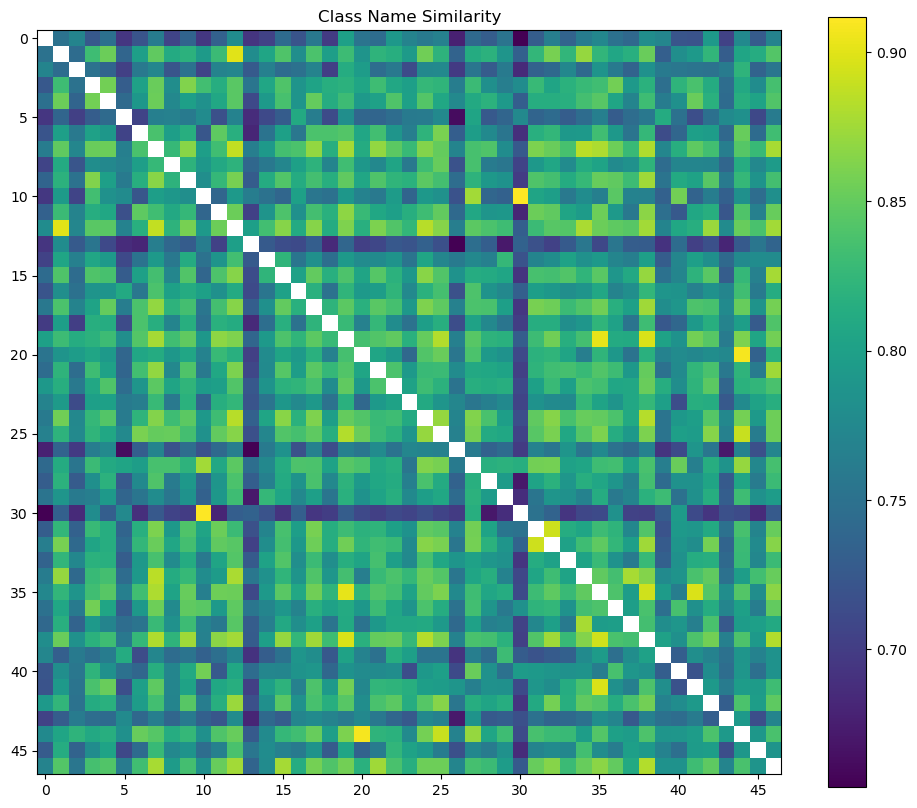

Text template similarity mean: 0.82958984375
Text template similarity std: 0.042633056640625
Rank 1: (1)blotchy - (12)flecked, similarity: 0.943359375
Rank 2: (34)smeared - (37)stained, similarity: 0.935546875
Rank 3: (10)dotted - (30)polka-dotted, similarity: 0.93408203125
Rank 4: (12)flecked - (34)smeared, similarity: 0.93359375
Rank 5: (25)meshed - (44)woven, similarity: 0.93115234375
Rank 6: (12)flecked - (15)gauzy, similarity: 0.92919921875
Rank 7: (1)blotchy - (34)smeared, similarity: 0.92822265625
Rank 8: (35)spiralled - (41)swirly, similarity: 0.92724609375
Rank 9: (10)dotted - (27)perforated, similarity: 0.9228515625
Rank 10: (12)flecked - (32)potholed, similarity: 0.9228515625


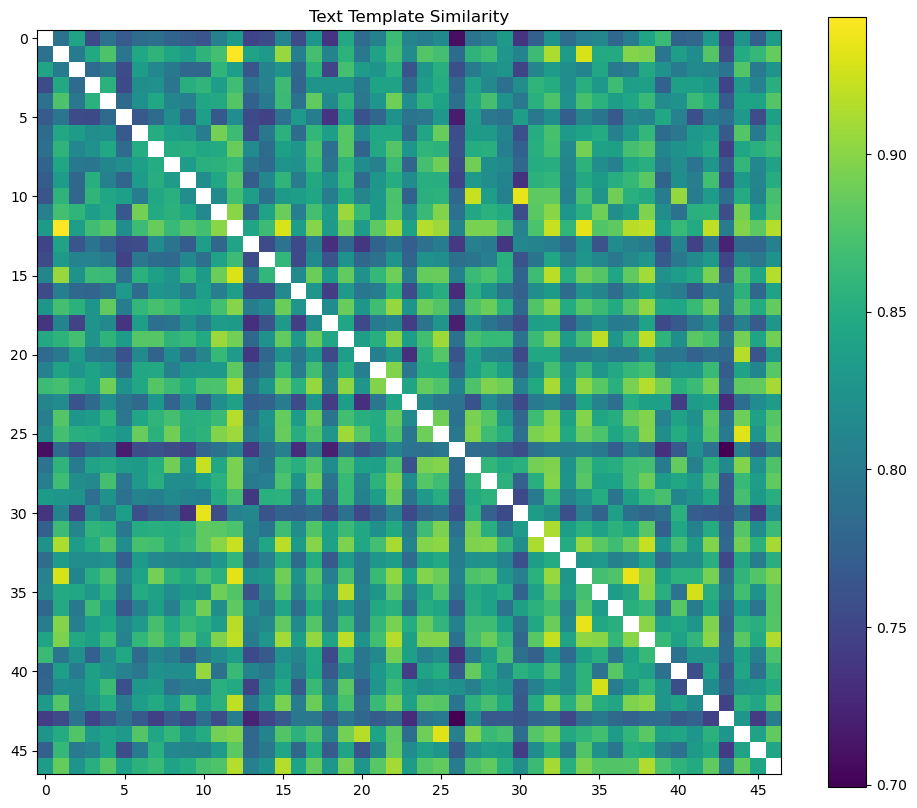

Original gpt-3 text similarity mean: 0.8427734375
Original gpt-3 text similarity std: 0.045562744140625
Rank 1: (35)spiralled - (41)swirly, similarity: 0.95361328125
Rank 2: (1)blotchy - (12)flecked, similarity: 0.9443359375
Rank 3: (28)pitted - (32)potholed, similarity: 0.9443359375
Rank 4: (10)dotted - (30)polka-dotted, similarity: 0.94287109375
Rank 5: (31)porous - (32)potholed, similarity: 0.939453125
Rank 6: (25)meshed - (44)woven, similarity: 0.939453125
Rank 7: (20)knitted - (44)woven, similarity: 0.93896484375
Rank 8: (17)grooved - (22)lined, similarity: 0.93896484375
Rank 9: (19)interlaced - (22)lined, similarity: 0.93798828125
Rank 10: (10)dotted - (27)perforated, similarity: 0.931640625


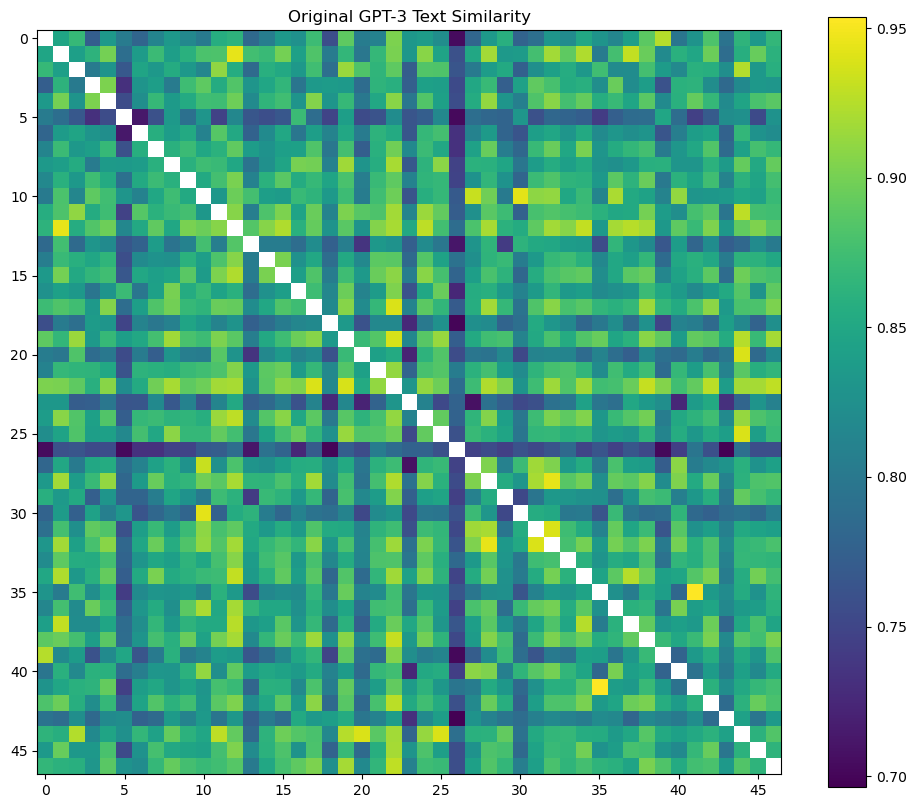

Filtered gpt-3 text similarity mean: 0.83984375
Filtered gpt-3 text similarity std: 0.046142578125
Rank 1: (35)spiralled - (41)swirly, similarity: 0.95263671875
Rank 2: (1)blotchy - (12)flecked, similarity: 0.943359375
Rank 3: (10)dotted - (30)polka-dotted, similarity: 0.943359375
Rank 4: (28)pitted - (32)potholed, similarity: 0.94287109375
Rank 5: (25)meshed - (44)woven, similarity: 0.93994140625
Rank 6: (31)porous - (32)potholed, similarity: 0.939453125
Rank 7: (17)grooved - (22)lined, similarity: 0.93896484375
Rank 8: (20)knitted - (44)woven, similarity: 0.9375
Rank 9: (19)interlaced - (22)lined, similarity: 0.93701171875
Rank 10: (10)dotted - (27)perforated, similarity: 0.931640625


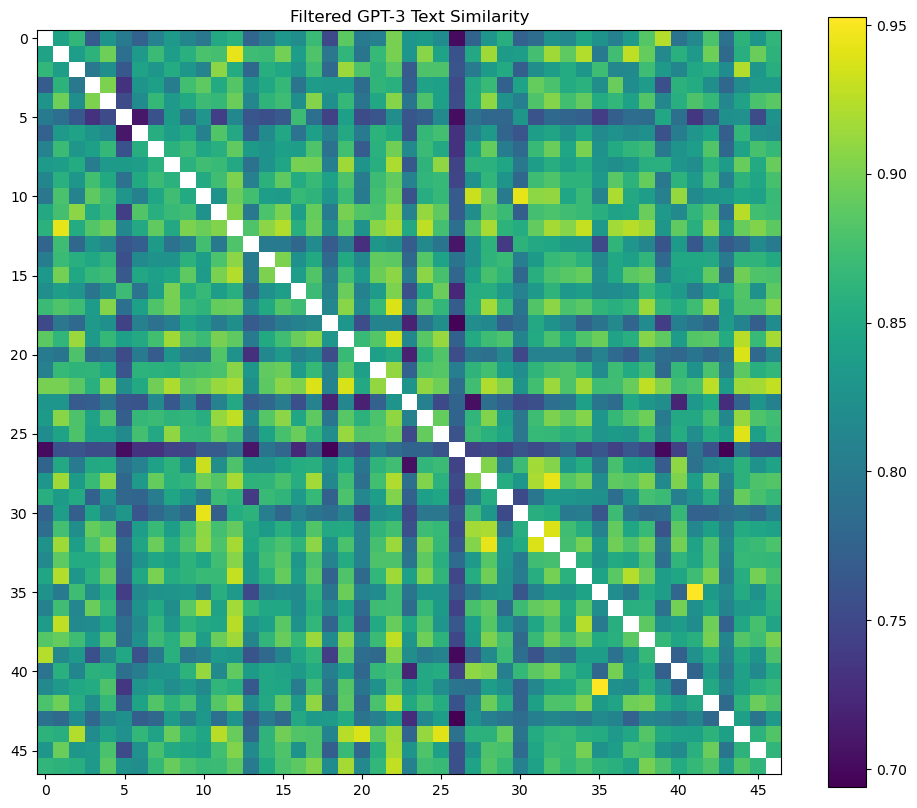

In [32]:
# Auto-similarity of text features
visualize_auto_similarity(cls_name_masked_similarity, 'Class Name')
visualize_auto_similarity(template_masked_similarity, 'Text Template')
visualize_auto_similarity(original_gpt3_masked_similarity, 'Original GPT-3 Text')
visualize_auto_similarity(filtered_gpt3_masked_similarity, 'Filtered GPT-3 Text')

Image similarity mean: 0.87255859375
Image similarity std: 0.04840087890625
Rank 1: (0)banded - (22)lined, similarity: 0.97607421875
Rank 2: (15)gauzy - (29)pleated, similarity: 0.974609375
Rank 3: (10)dotted - (30)polka-dotted, similarity: 0.97314453125
Rank 4: (25)meshed - (27)perforated, similarity: 0.97314453125
Rank 5: (16)grid - (27)perforated, similarity: 0.97021484375
Rank 6: (16)grid - (25)meshed, similarity: 0.96630859375
Rank 7: (28)pitted - (31)porous, similarity: 0.96630859375
Rank 8: (1)blotchy - (28)pitted, similarity: 0.962890625
Rank 9: (1)blotchy - (34)smeared, similarity: 0.96044921875
Rank 10: (1)blotchy - (37)stained, similarity: 0.9580078125


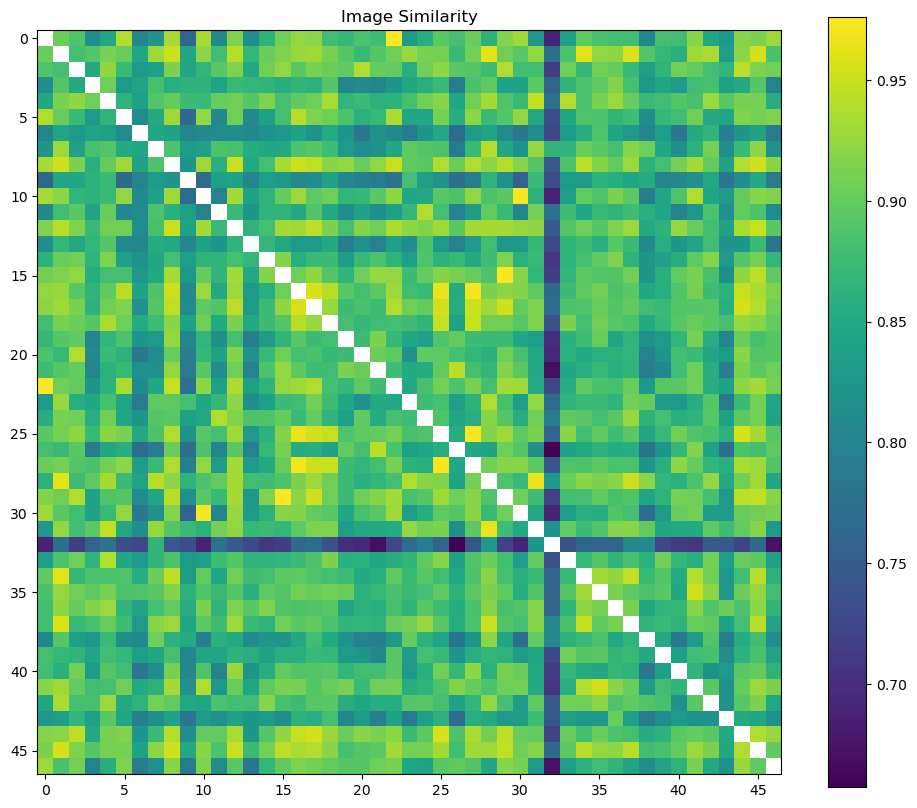

Image to class name similarity mean: 0.21533203125
Image to class name similarity std: 0.020538330078125
Image to class name similarity diagonal mean: 0.2568359375
Image to class name similarity diagonal std: 0.0223388671875
Image to class name similarity non-diagonal mean: 0.2144775390625
Image to class name similarity non-diagonal std: 0.01953125
Image to class name similarity diagonal mean to non-diagonal mean ratio: 1.197265625
Rank 1: (30)polka-dotted - (10)dotted, similarity: 0.291259765625
Rank 2: (10)dotted - (30)polka-dotted, similarity: 0.288818359375
Rank 3: (0)banded - (39)striped, similarity: 0.27685546875
Rank 4: (25)meshed - (27)perforated, similarity: 0.27294921875
Rank 5: (27)perforated - (10)dotted, similarity: 0.26953125
Rank 6: (16)grid - (27)perforated, similarity: 0.263916015625
Rank 7: (40)studded - (27)perforated, similarity: 0.26220703125
Rank 8: (22)lined - (39)striped, similarity: 0.26123046875
Rank 9: (30)polka-dotted - (27)perforated, similarity: 0.26098632

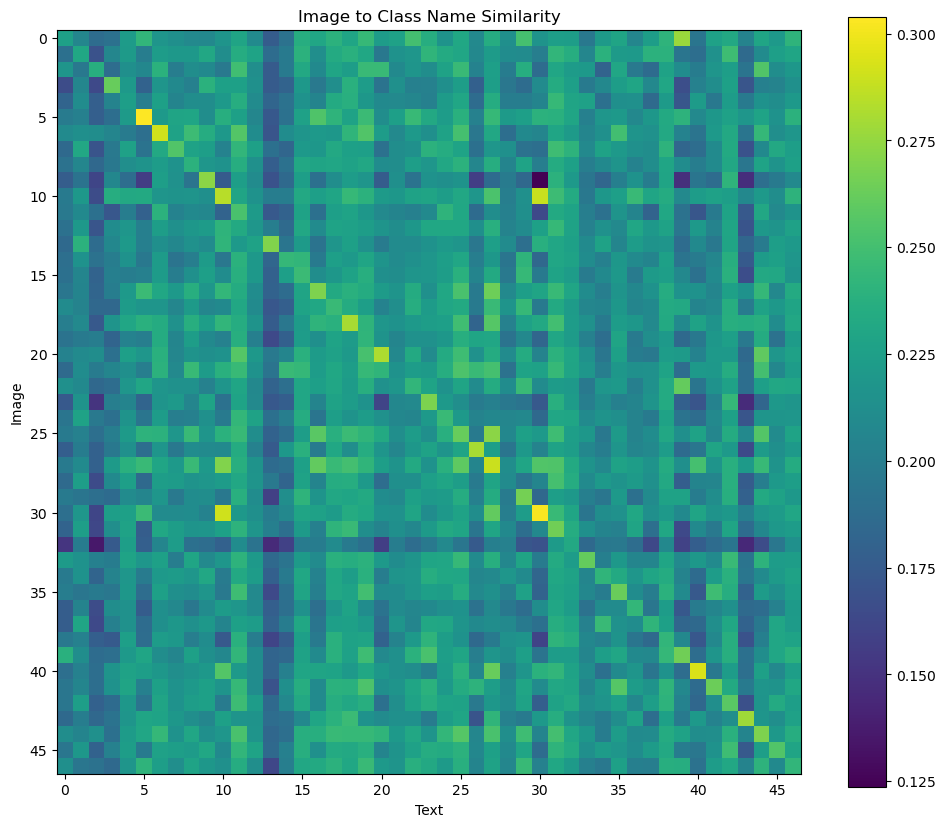

Rank 1: (0)banded - (39)striped, error rate: 0.8611111111111112
Rank 2: (22)lined - (39)striped, error rate: 0.6111111111111112
Rank 3: (10)dotted - (30)polka-dotted, error rate: 0.5833333333333334
Rank 4: (25)meshed - (27)perforated, error rate: 0.5833333333333334
Rank 5: (28)pitted - (31)porous, error rate: 0.5277777777777778
Rank 6: (16)grid - (27)perforated, error rate: 0.3611111111111111
Rank 7: (24)matted - (11)fibrous, error rate: 0.3611111111111111
Rank 8: (15)gauzy - (29)pleated, error rate: 0.3055555555555556
Rank 9: (14)frilly - (29)pleated, error rate: 0.2777777777777778
Rank 10: (37)stained - (34)smeared, error rate: 0.2777777777777778
Rank 11: (17)grooved - (29)pleated, error rate: 0.2777777777777778
Rank 12: (4)bumpy - (18)honeycombed, error rate: 0.2777777777777778
Rank 13: (4)bumpy - (31)porous, error rate: 0.25
Rank 14: (46)zigzagged - (29)pleated, error rate: 0.25
Rank 15: (2)braided - (44)woven, error rate: 0.2222222222222222
Rank 16: (21)lacelike - (14)frilly, erro

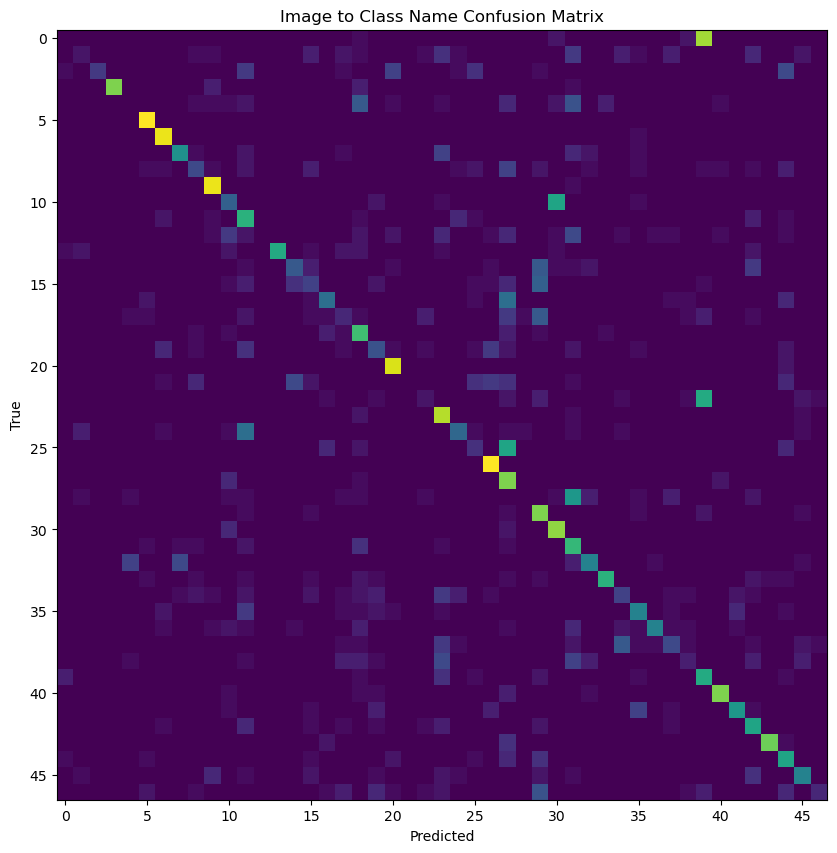

Image to text template (centroid) similarity mean: 0.2362060546875
Image to text template (centroid) similarity std: 0.018280029296875
Image to text template (centroid) similarity diagonal mean: 0.279541015625
Image to text template (centroid) similarity diagonal std: 0.0232391357421875
Image to text template (centroid) similarity non-diagonal mean: 0.2352294921875
Image to text template (centroid) similarity non-diagonal std: 0.0169525146484375
Image to text template (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.1884765625
Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.3193359375
Rank 2: (30)polka-dotted - (10)dotted, similarity: 0.303955078125
Rank 3: (0)banded - (39)striped, similarity: 0.297119140625
Rank 4: (27)perforated - (10)dotted, similarity: 0.294677734375
Rank 5: (27)perforated - (30)polka-dotted, similarity: 0.29443359375
Rank 6: (25)meshed - (27)perforated, similarity: 0.2900390625
Rank 7: (27)perforated - (40)studded, similarity: 0.28515625
Rank

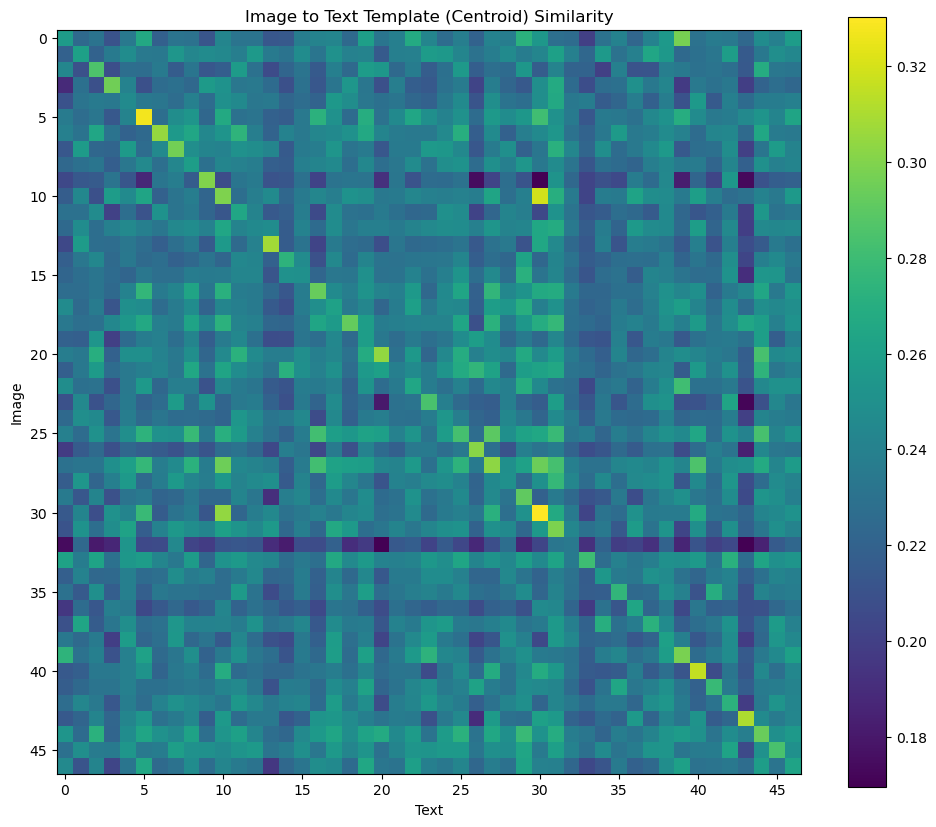

Rank 1: (10)dotted - (30)polka-dotted, error rate: 0.9166666666666666
Rank 2: (0)banded - (39)striped, error rate: 0.8333333333333334
Rank 3: (32)potholed - (4)bumpy, error rate: 0.6666666666666666
Rank 4: (22)lined - (39)striped, error rate: 0.6388888888888888
Rank 5: (28)pitted - (31)porous, error rate: 0.5833333333333334
Rank 6: (15)gauzy - (29)pleated, error rate: 0.5277777777777778
Rank 7: (17)grooved - (29)pleated, error rate: 0.4722222222222222
Rank 8: (25)meshed - (27)perforated, error rate: 0.3888888888888889
Rank 9: (46)zigzagged - (5)chequered, error rate: 0.3611111111111111
Rank 10: (19)interlaced - (26)paisley, error rate: 0.3333333333333333
Rank 11: (21)lacelike - (26)paisley, error rate: 0.3333333333333333
Rank 12: (4)bumpy - (31)porous, error rate: 0.3333333333333333
Rank 13: (35)spiralled - (41)swirly, error rate: 0.25
Rank 14: (21)lacelike - (14)frilly, error rate: 0.25
Rank 15: (14)frilly - (29)pleated, error rate: 0.25
Rank 16: (41)swirly - (26)paisley, error rate: 

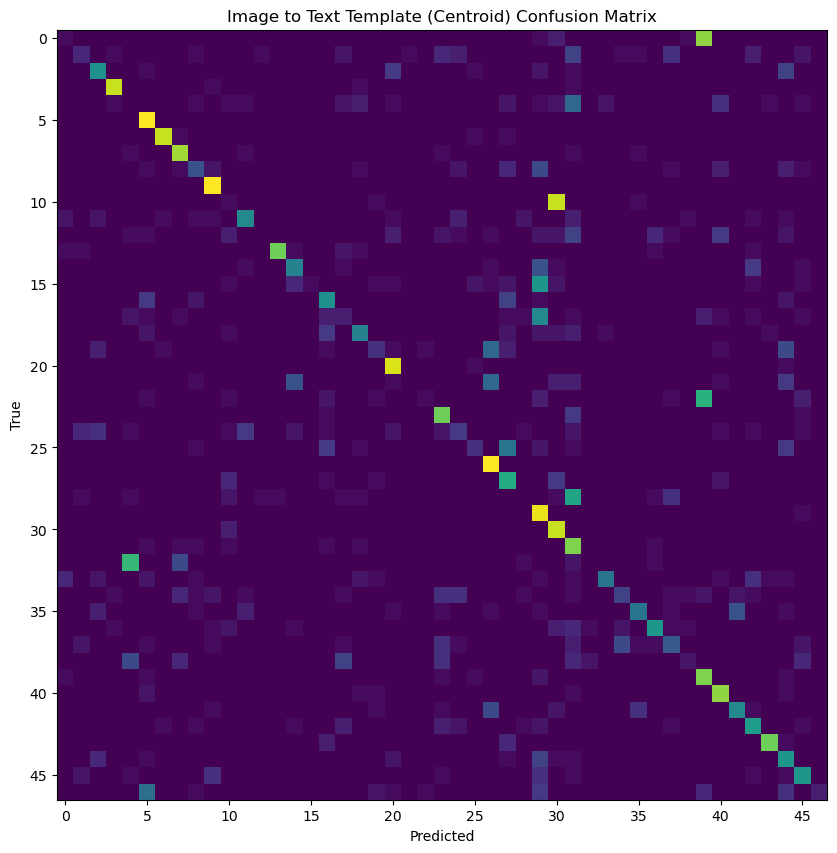

Image to text template (individual avg) similarity mean: 0.21840550005435944
Image to text template (individual avg) similarity std: 0.017073074355721474
Image to text template (individual avg) similarity diagonal mean: 0.25859686732292175
Image to text template (individual avg) similarity diagonal std: 0.021459579467773438
Image to text template (individual avg) similarity non-diagonal mean: 0.21753178536891937
Image to text template (individual avg) similarity non-diagonal std: 0.01587248593568802
Image to text template (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.1887773275375366
Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.296875
Rank 2: (30)polka-dotted - (10)dotted, similarity: 0.279052734375
Rank 3: (27)perforated - (30)polka-dotted, similarity: 0.273681640625
Rank 4: (0)banded - (39)striped, similarity: 0.27294921875
Rank 5: (27)perforated - (10)dotted, similarity: 0.2705078125
Rank 6: (25)meshed - (27)perforated, similarity: 0.27001953125
Ran

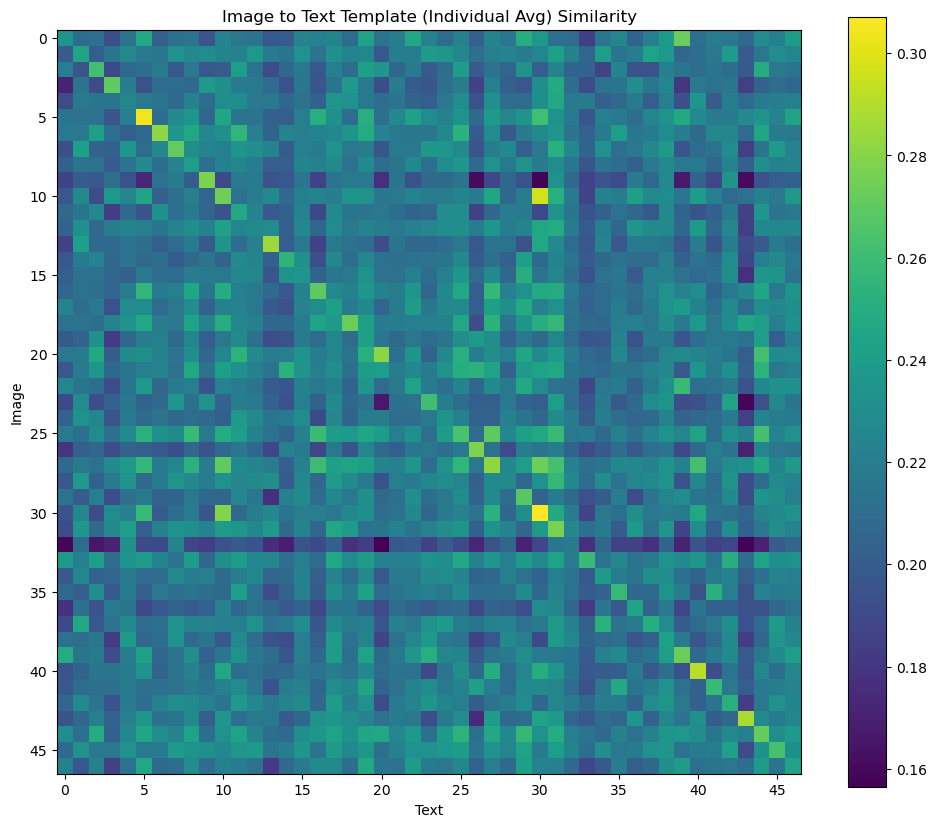

Rank 1: (10)dotted - (30)polka-dotted, error rate: 0.9444444444444444
Rank 2: (0)banded - (39)striped, error rate: 0.8055555555555556
Rank 3: (32)potholed - (4)bumpy, error rate: 0.6666666666666666
Rank 4: (22)lined - (39)striped, error rate: 0.6111111111111112
Rank 5: (28)pitted - (31)porous, error rate: 0.5555555555555556
Rank 6: (15)gauzy - (29)pleated, error rate: 0.5277777777777778
Rank 7: (25)meshed - (27)perforated, error rate: 0.4444444444444444
Rank 8: (17)grooved - (29)pleated, error rate: 0.4444444444444444
Rank 9: (46)zigzagged - (5)chequered, error rate: 0.3888888888888889
Rank 10: (4)bumpy - (31)porous, error rate: 0.3055555555555556
Rank 11: (21)lacelike - (26)paisley, error rate: 0.2777777777777778
Rank 12: (21)lacelike - (14)frilly, error rate: 0.2777777777777778
Rank 13: (35)spiralled - (41)swirly, error rate: 0.25
Rank 14: (37)stained - (34)smeared, error rate: 0.25
Rank 15: (19)interlaced - (26)paisley, error rate: 0.25
Rank 16: (14)frilly - (29)pleated, error rate:

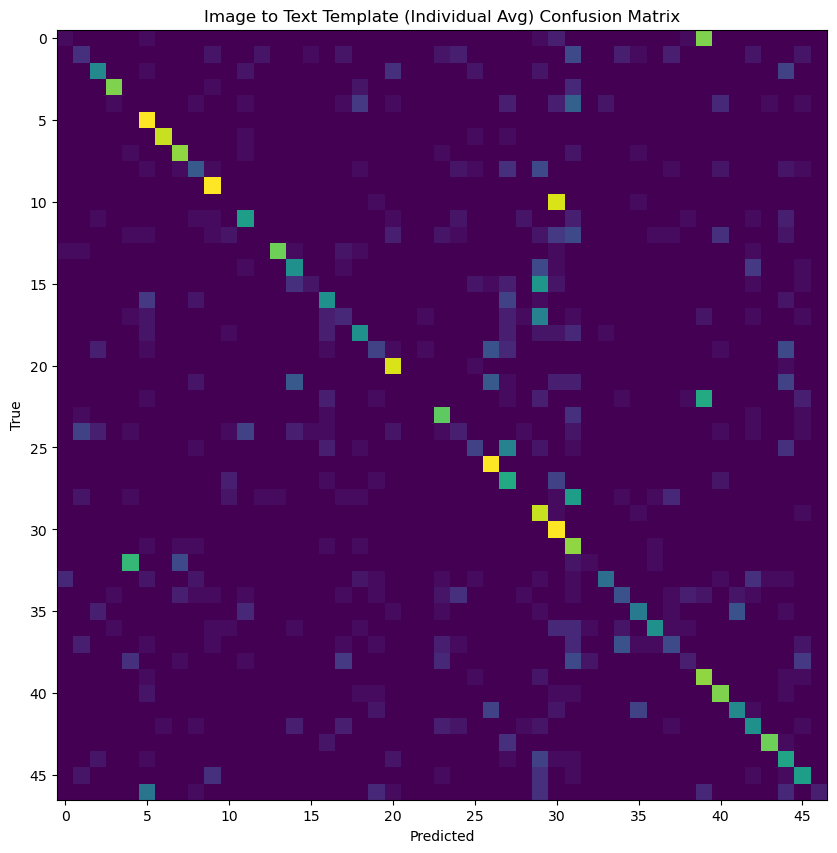

Image to original gpt-3 text (centroid) similarity mean: 0.25146484375
Image to original gpt-3 text (centroid) similarity std: 0.0200958251953125
Image to original gpt-3 text (centroid) similarity diagonal mean: 0.299560546875
Image to original gpt-3 text (centroid) similarity diagonal std: 0.0206451416015625
Image to original gpt-3 text (centroid) similarity non-diagonal mean: 0.25048828125
Image to original gpt-3 text (centroid) similarity non-diagonal std: 0.0187530517578125
Image to original gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.1962890625
Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.333251953125
Rank 2: (30)polka-dotted - (10)dotted, similarity: 0.325927734375
Rank 3: (0)banded - (39)striped, similarity: 0.320556640625
Rank 4: (27)perforated - (10)dotted, similarity: 0.307861328125
Rank 5: (18)honeycombed - (43)waffled, similarity: 0.30322265625
Rank 6: (21)lacelike - (26)paisley, similarity: 0.302734375
Rank 7: (22)lined - (39)stripe

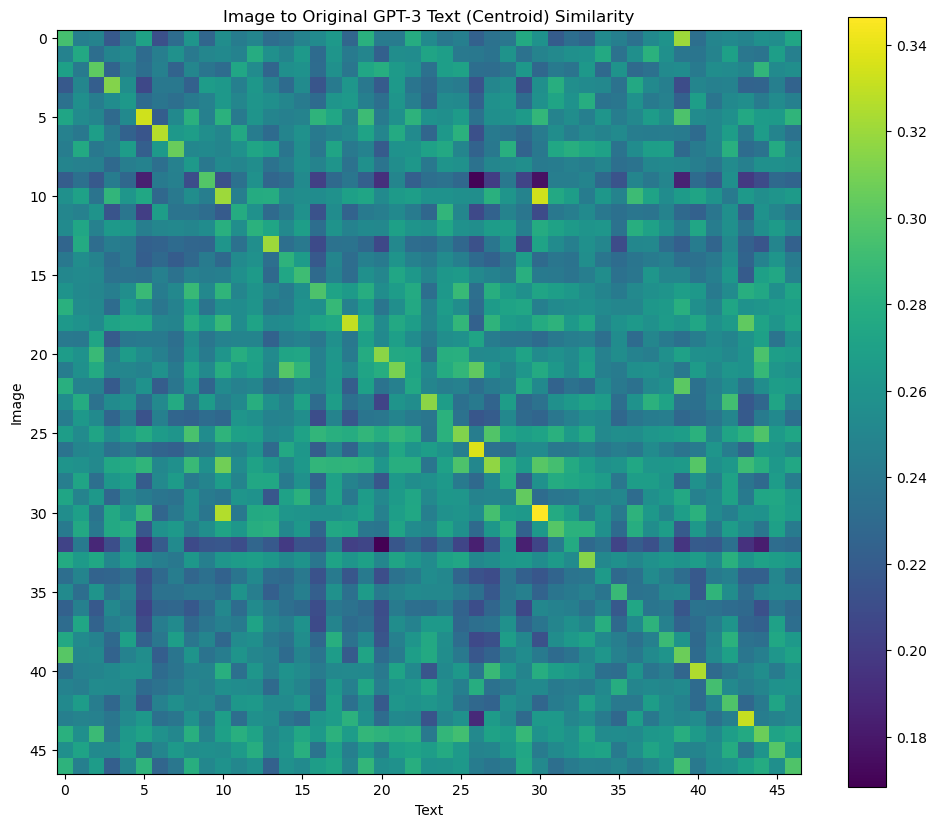

Rank 1: (0)banded - (39)striped, error rate: 0.9444444444444444
Rank 2: (10)dotted - (30)polka-dotted, error rate: 0.7777777777777778
Rank 3: (22)lined - (39)striped, error rate: 0.6944444444444444
Rank 4: (11)fibrous - (24)matted, error rate: 0.5555555555555556
Rank 5: (4)bumpy - (33)scaly, error rate: 0.4444444444444444
Rank 6: (41)swirly - (26)paisley, error rate: 0.3611111111111111
Rank 7: (19)interlaced - (26)paisley, error rate: 0.3055555555555556
Rank 8: (17)grooved - (39)striped, error rate: 0.2777777777777778
Rank 9: (1)blotchy - (23)marbled, error rate: 0.25
Rank 10: (37)stained - (34)smeared, error rate: 0.2222222222222222
Rank 11: (12)flecked - (36)sprinkled, error rate: 0.2222222222222222
Rank 12: (21)lacelike - (26)paisley, error rate: 0.2222222222222222
Rank 13: (35)spiralled - (41)swirly, error rate: 0.2222222222222222
Rank 14: (19)interlaced - (2)braided, error rate: 0.2222222222222222
Rank 15: (46)zigzagged - (39)striped, error rate: 0.2222222222222222
Rank 16: (28)pi

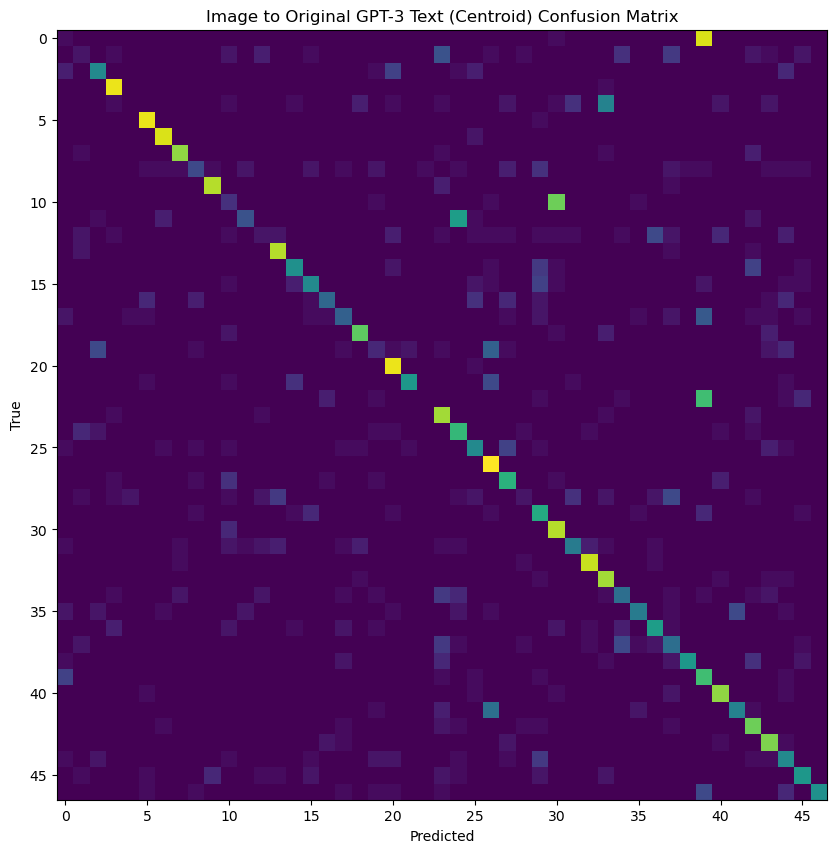

Image to original gpt-3 text (individual avg) similarity mean: 0.2373283952474594
Image to original gpt-3 text (individual avg) similarity std: 0.01906559057533741
Image to original gpt-3 text (individual avg) similarity diagonal mean: 0.28292521834373474
Image to original gpt-3 text (individual avg) similarity diagonal std: 0.020328601822257042
Image to original gpt-3 text (individual avg) similarity non-diagonal mean: 0.23633715510368347
Image to original gpt-3 text (individual avg) similarity non-diagonal std: 0.01778300851583481
Image to original gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.1971254348754883
Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.319091796875
Rank 2: (30)polka-dotted - (10)dotted, similarity: 0.30859375
Rank 3: (0)banded - (39)striped, similarity: 0.302490234375
Rank 4: (27)perforated - (10)dotted, similarity: 0.29150390625
Rank 5: (21)lacelike - (26)paisley, similarity: 0.290771484375
Rank 6: (27)perforated - (30)

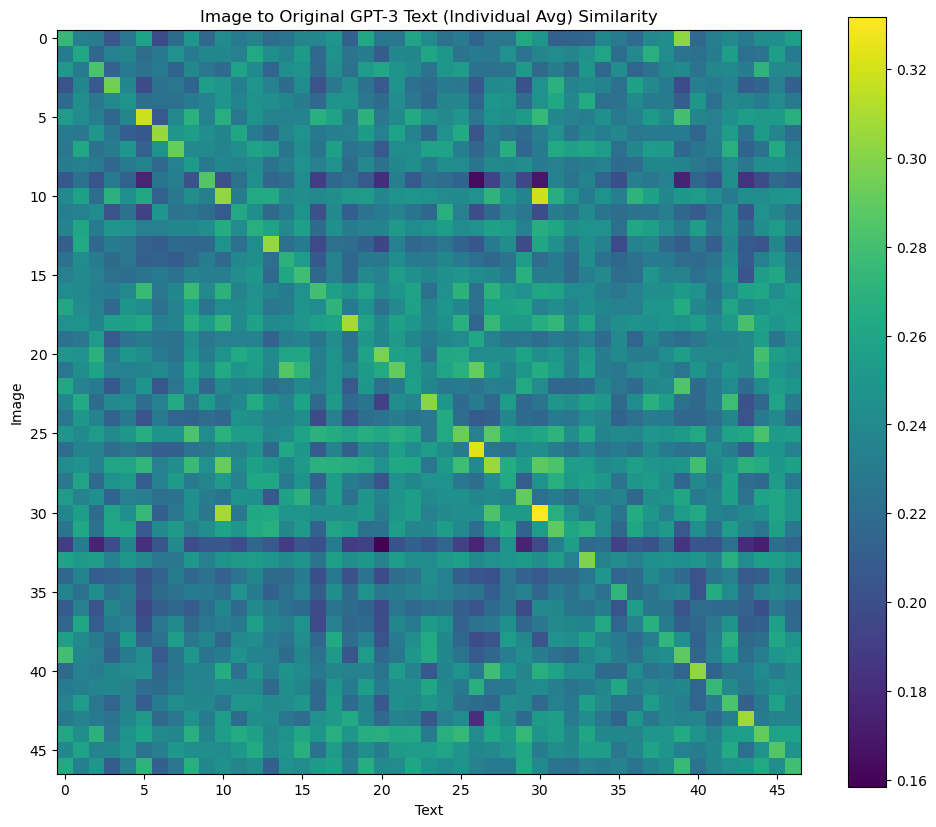

Rank 1: (0)banded - (39)striped, error rate: 0.9444444444444444
Rank 2: (10)dotted - (30)polka-dotted, error rate: 0.8333333333333334
Rank 3: (22)lined - (39)striped, error rate: 0.6944444444444444
Rank 4: (11)fibrous - (24)matted, error rate: 0.5
Rank 5: (41)swirly - (26)paisley, error rate: 0.4722222222222222
Rank 6: (19)interlaced - (26)paisley, error rate: 0.3888888888888889
Rank 7: (4)bumpy - (33)scaly, error rate: 0.3888888888888889
Rank 8: (25)meshed - (27)perforated, error rate: 0.3611111111111111
Rank 9: (21)lacelike - (26)paisley, error rate: 0.3333333333333333
Rank 10: (28)pitted - (37)stained, error rate: 0.2777777777777778
Rank 11: (28)pitted - (31)porous, error rate: 0.2777777777777778
Rank 12: (1)blotchy - (23)marbled, error rate: 0.25
Rank 13: (17)grooved - (39)striped, error rate: 0.25
Rank 14: (1)blotchy - (37)stained, error rate: 0.2222222222222222
Rank 15: (4)bumpy - (31)porous, error rate: 0.2222222222222222
Rank 16: (46)zigzagged - (39)striped, error rate: 0.22222

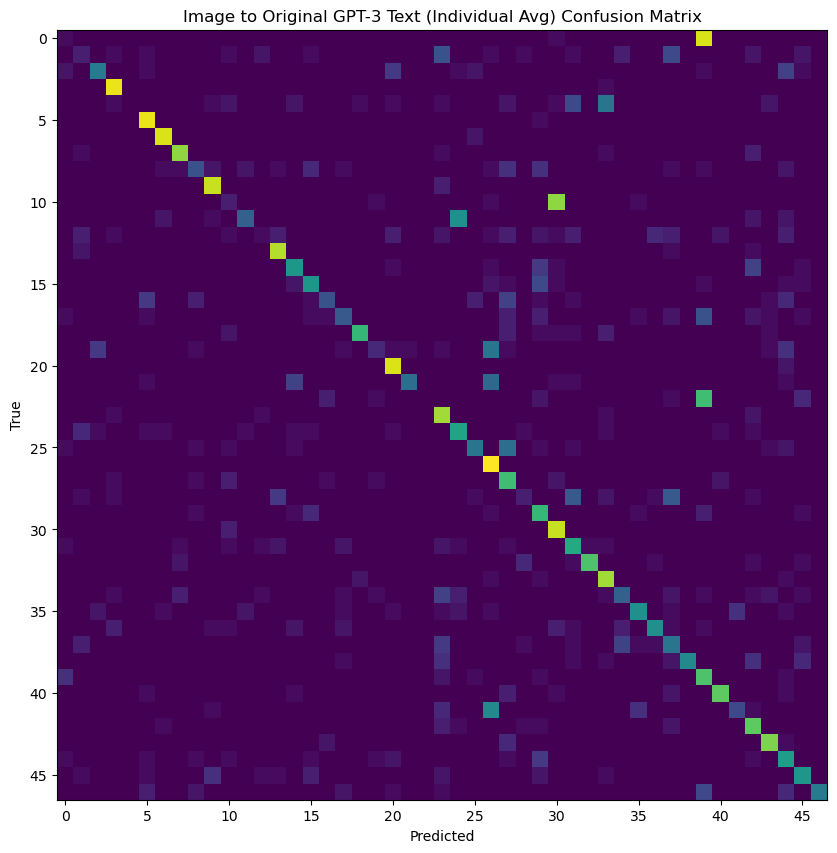

Image to filtered gpt-3 text (centroid) similarity mean: 0.251220703125
Image to filtered gpt-3 text (centroid) similarity std: 0.02020263671875
Image to filtered gpt-3 text (centroid) similarity diagonal mean: 0.2998046875
Image to filtered gpt-3 text (centroid) similarity diagonal std: 0.0205535888671875
Image to filtered gpt-3 text (centroid) similarity non-diagonal mean: 0.250244140625
Image to filtered gpt-3 text (centroid) similarity non-diagonal std: 0.01885986328125
Image to filtered gpt-3 text (centroid) similarity diagonal mean to non-diagonal mean ratio: 1.1982421875
Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.333251953125
Rank 2: (30)polka-dotted - (10)dotted, similarity: 0.326171875
Rank 3: (0)banded - (39)striped, similarity: 0.3212890625
Rank 4: (27)perforated - (10)dotted, similarity: 0.307373046875
Rank 5: (18)honeycombed - (43)waffled, similarity: 0.304931640625
Rank 6: (21)lacelike - (26)paisley, similarity: 0.302734375
Rank 7: (22)lined - (39)striped, simil

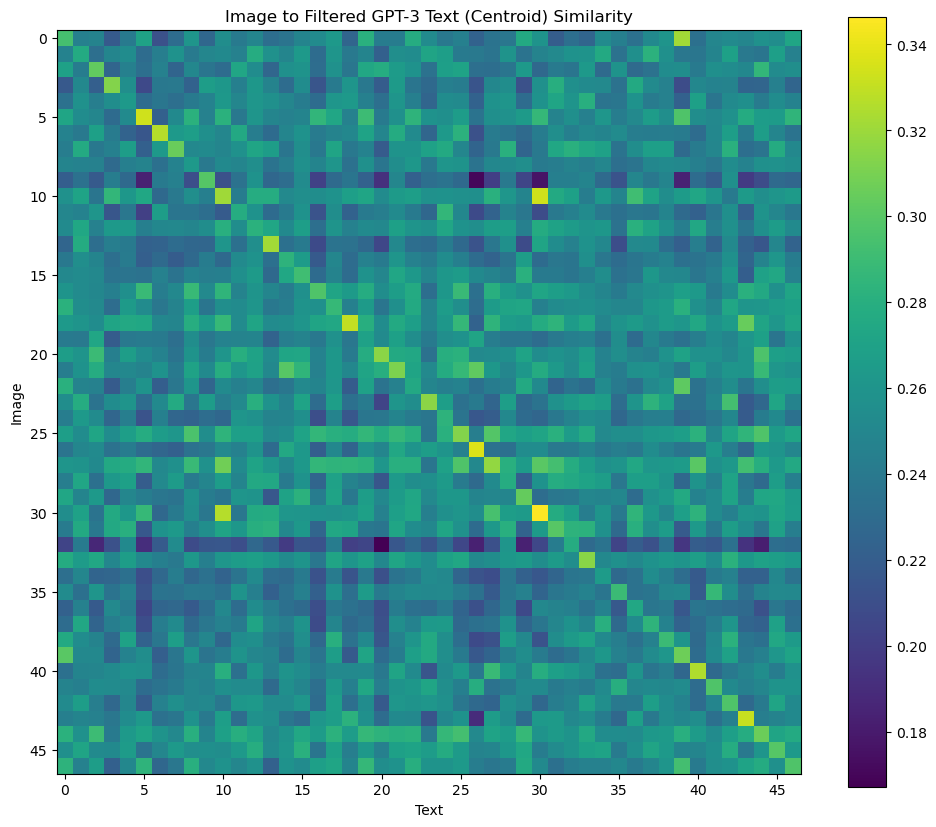

Rank 1: (0)banded - (39)striped, error rate: 0.9444444444444444
Rank 2: (10)dotted - (30)polka-dotted, error rate: 0.7777777777777778
Rank 3: (22)lined - (39)striped, error rate: 0.7222222222222222
Rank 4: (11)fibrous - (24)matted, error rate: 0.5555555555555556
Rank 5: (4)bumpy - (33)scaly, error rate: 0.4444444444444444
Rank 6: (35)spiralled - (41)swirly, error rate: 0.3333333333333333
Rank 7: (41)swirly - (26)paisley, error rate: 0.3333333333333333
Rank 8: (19)interlaced - (26)paisley, error rate: 0.3055555555555556
Rank 9: (17)grooved - (39)striped, error rate: 0.2777777777777778
Rank 10: (12)flecked - (36)sprinkled, error rate: 0.25
Rank 11: (1)blotchy - (23)marbled, error rate: 0.25
Rank 12: (19)interlaced - (2)braided, error rate: 0.2222222222222222
Rank 13: (21)lacelike - (26)paisley, error rate: 0.2222222222222222
Rank 14: (46)zigzagged - (39)striped, error rate: 0.2222222222222222
Rank 15: (25)meshed - (27)perforated, error rate: 0.19444444444444445
Rank 16: (14)frilly - (42)

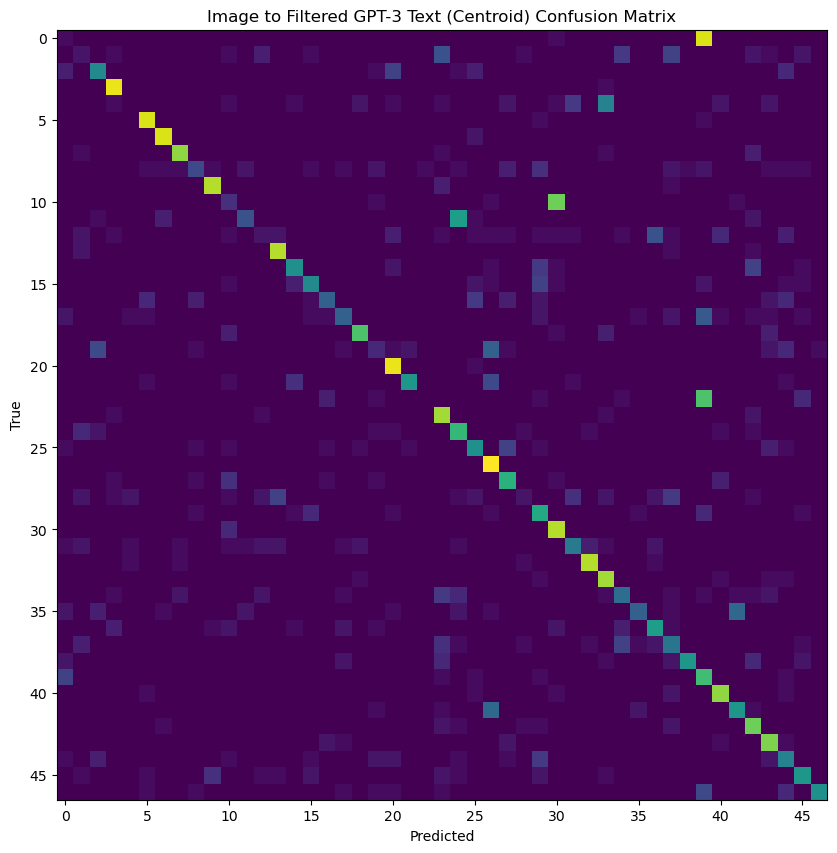

Image to filtered gpt-3 text (individual avg) similarity mean: 0.23773859441280365
Image to filtered gpt-3 text (individual avg) similarity std: 0.019151728600263596
Image to filtered gpt-3 text (individual avg) similarity diagonal mean: 0.2836991846561432
Image to filtered gpt-3 text (individual avg) similarity diagonal std: 0.02020890824496746
Image to filtered gpt-3 text (individual avg) similarity non-diagonal mean: 0.23673944175243378
Image to filtered gpt-3 text (individual avg) similarity non-diagonal std: 0.017859579995274544
Image to filtered gpt-3 text (individual avg) similarity diagonal mean to non-diagonal mean ratio: 1.1983604431152344
Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.319091796875
Rank 2: (30)polka-dotted - (10)dotted, similarity: 0.30908203125
Rank 3: (0)banded - (39)striped, similarity: 0.303955078125
Rank 4: (27)perforated - (10)dotted, similarity: 0.29150390625
Rank 5: (21)lacelike - (26)paisley, similarity: 0.290771484375
Rank 6: (27)perforated - 

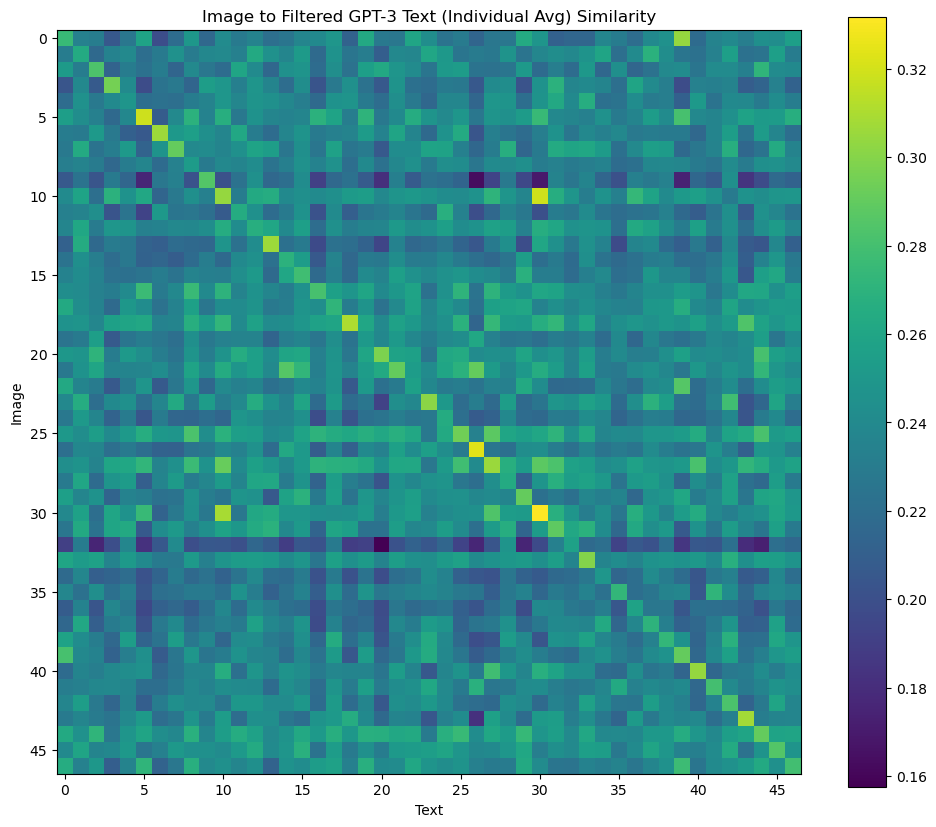

Rank 1: (0)banded - (39)striped, error rate: 0.9444444444444444
Rank 2: (10)dotted - (30)polka-dotted, error rate: 0.8333333333333334
Rank 3: (22)lined - (39)striped, error rate: 0.7222222222222222
Rank 4: (11)fibrous - (24)matted, error rate: 0.4722222222222222
Rank 5: (4)bumpy - (33)scaly, error rate: 0.4444444444444444
Rank 6: (35)spiralled - (41)swirly, error rate: 0.3611111111111111
Rank 7: (41)swirly - (26)paisley, error rate: 0.3611111111111111
Rank 8: (19)interlaced - (26)paisley, error rate: 0.3611111111111111
Rank 9: (25)meshed - (27)perforated, error rate: 0.3333333333333333
Rank 10: (21)lacelike - (26)paisley, error rate: 0.3333333333333333
Rank 11: (17)grooved - (39)striped, error rate: 0.3055555555555556
Rank 12: (28)pitted - (31)porous, error rate: 0.2777777777777778
Rank 13: (1)blotchy - (37)stained, error rate: 0.25
Rank 14: (1)blotchy - (23)marbled, error rate: 0.25
Rank 15: (46)zigzagged - (39)striped, error rate: 0.25
Rank 16: (28)pitted - (13)freckled, error rate: 

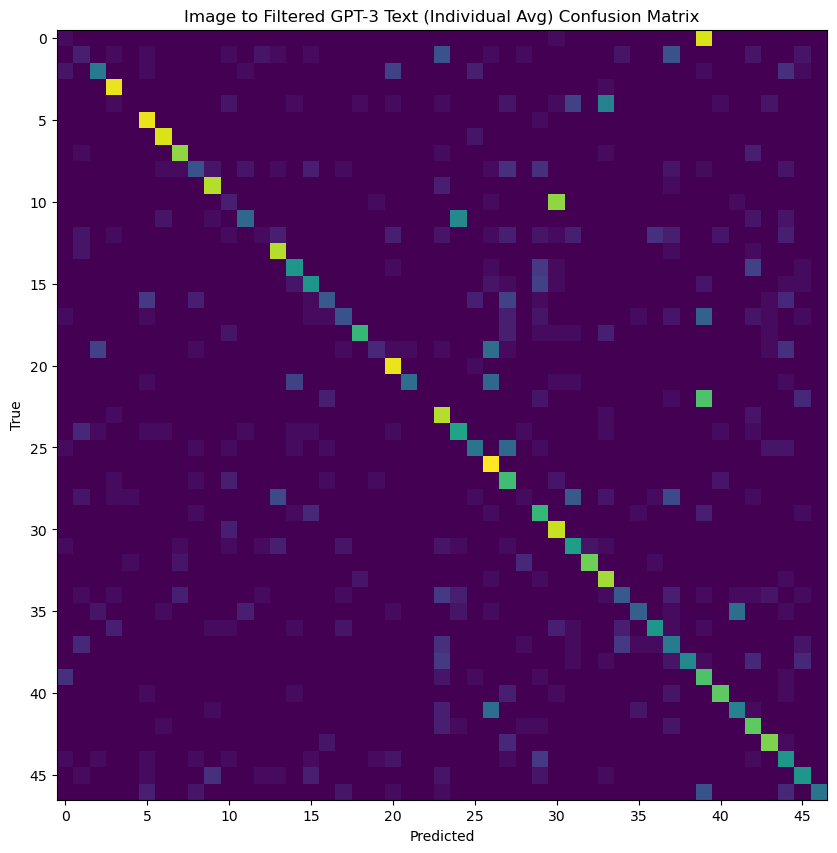

In [33]:
# Auto-similarity of image features
visualize_auto_similarity(img_masked_similarity, 'Image')

# Image to text similarity
visualize_cross_similarity(img_cls_name_similarity, cls_name_cm, 'Image to Class Name')
visualize_cross_similarity(img_template_cls_similarity, template_cls_cm, 'Image to Text Template (Centroid)')
visualize_cross_similarity(img_template_text_similarity, template_text_cm, 'Image to Text Template (Individual Avg)')
visualize_cross_similarity(img_original_gpt3_cls_similarity, original_gpt3_cls_cm, 'Image to Original GPT-3 Text (Centroid)')
visualize_cross_similarity(img_original_gpt3_text_similarity, original_gpt3_text_cm, 'Image to Original GPT-3 Text (Individual Avg)')
visualize_cross_similarity(img_filtered_gpt3_cls_similarity, filtered_gpt3_cls_cm, 'Image to Filtered GPT-3 Text (Centroid)')
visualize_cross_similarity(img_filtered_gpt3_text_similarity, filtered_gpt3_text_cm, 'Image to Filtered GPT-3 Text (Individual Avg)')

In [34]:
# Concatenate all features and labels to be used for plotting
all_label_ids = np.concatenate([cls_name_label_ids, template_label_ids, original_gpt3_label_ids, filtered_gpt3_label_ids])
all_features = np.concatenate([cls_name_features, template_text_features, original_gpt3_text_features, filtered_gpt3_text_features])

cls_name_start_idx = 0
cls_name_end_idx = len(cls_name_features)
template_start_idx = len(cls_name_features)
template_end_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_start_idx = len(cls_name_features) + len(template_text_features)
original_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_start_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features)
filtered_gpt3_end_idx = len(cls_name_features) + len(template_text_features) + len(original_gpt3_text_features) + len(filtered_gpt3_text_features)

In [35]:
import sklearn.manifold

tsne = sklearn.manifold.TSNE(n_components=2, random_state=42, metric='cosine', perplexity=100)
transformed_features = tsne.fit_transform(all_features)

In [36]:
import matplotlib.pyplot as plt

def plot_features_2d(features, label_ids, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(features[:, 0], features[:, 1], c=label_ids, cmap='hsv')
    for label_id in range(len(cls_names_sorted)):
        plt.annotate(label_id, (features[label_ids == label_id, 0].mean(), features[label_ids == label_id, 1].mean()), ha='center', va='center', fontsize=12)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    plt.show()

Rank 1: (10)dotted - (30)polka-dotted, similarity: 0.91162109375
Rank 2: (20)knitted - (44)woven, similarity: 0.90771484375
Rank 3: (19)interlaced - (35)spiralled, similarity: 0.90185546875
Rank 4: (1)blotchy - (12)flecked, similarity: 0.900390625
Rank 5: (19)interlaced - (38)stratified, similarity: 0.89697265625
Rank 6: (35)spiralled - (41)swirly, similarity: 0.89697265625
Rank 7: (35)spiralled - (38)stratified, similarity: 0.89306640625
Rank 8: (31)porous - (32)potholed, similarity: 0.89208984375
Rank 9: (25)meshed - (44)woven, similarity: 0.89013671875
Rank 10: (7)cracked - (12)flecked, similarity: 0.8876953125


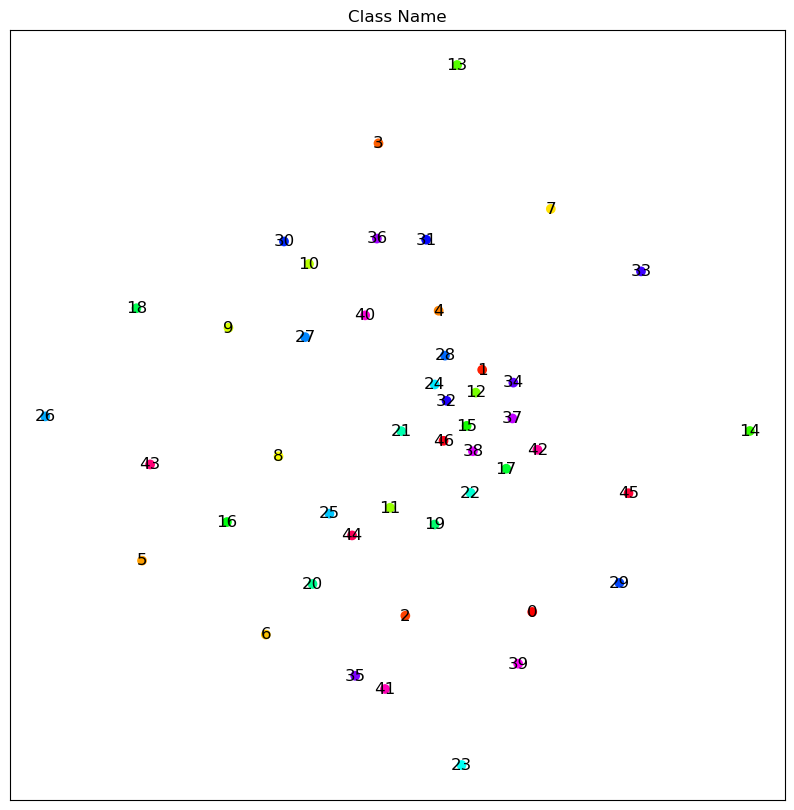

Rank 1: (1)blotchy - (12)flecked, similarity: 0.943359375
Rank 2: (34)smeared - (37)stained, similarity: 0.935546875
Rank 3: (10)dotted - (30)polka-dotted, similarity: 0.93408203125
Rank 4: (12)flecked - (34)smeared, similarity: 0.93359375
Rank 5: (25)meshed - (44)woven, similarity: 0.93115234375
Rank 6: (12)flecked - (15)gauzy, similarity: 0.92919921875
Rank 7: (1)blotchy - (34)smeared, similarity: 0.92822265625
Rank 8: (35)spiralled - (41)swirly, similarity: 0.92724609375
Rank 9: (10)dotted - (27)perforated, similarity: 0.9228515625
Rank 10: (12)flecked - (32)potholed, similarity: 0.9228515625


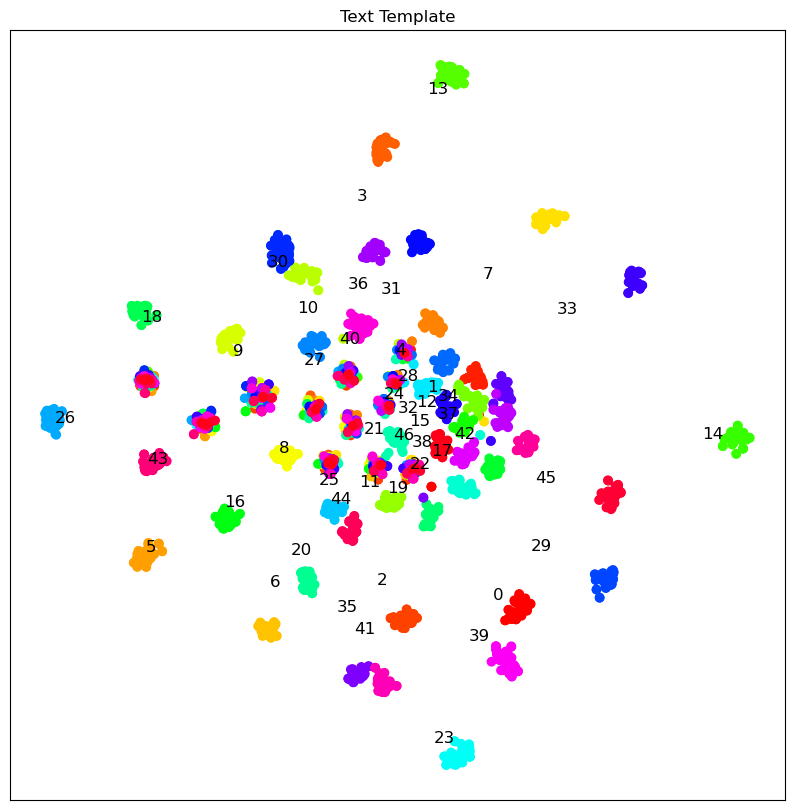

Rank 1: (35)spiralled - (41)swirly, similarity: 0.95361328125
Rank 2: (1)blotchy - (12)flecked, similarity: 0.9443359375
Rank 3: (28)pitted - (32)potholed, similarity: 0.9443359375
Rank 4: (10)dotted - (30)polka-dotted, similarity: 0.94287109375
Rank 5: (31)porous - (32)potholed, similarity: 0.939453125
Rank 6: (25)meshed - (44)woven, similarity: 0.939453125
Rank 7: (20)knitted - (44)woven, similarity: 0.93896484375
Rank 8: (17)grooved - (22)lined, similarity: 0.93896484375
Rank 9: (19)interlaced - (22)lined, similarity: 0.93798828125
Rank 10: (10)dotted - (27)perforated, similarity: 0.931640625


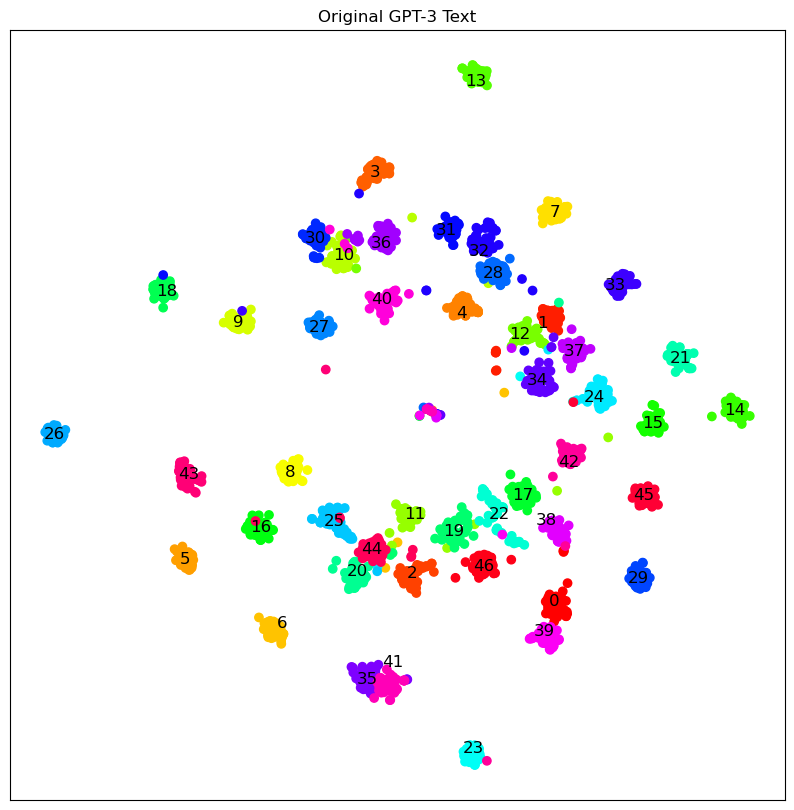

Rank 1: (35)spiralled - (41)swirly, similarity: 0.95263671875
Rank 2: (1)blotchy - (12)flecked, similarity: 0.943359375
Rank 3: (10)dotted - (30)polka-dotted, similarity: 0.943359375
Rank 4: (28)pitted - (32)potholed, similarity: 0.94287109375
Rank 5: (25)meshed - (44)woven, similarity: 0.93994140625
Rank 6: (31)porous - (32)potholed, similarity: 0.939453125
Rank 7: (17)grooved - (22)lined, similarity: 0.93896484375
Rank 8: (20)knitted - (44)woven, similarity: 0.9375
Rank 9: (19)interlaced - (22)lined, similarity: 0.93701171875
Rank 10: (10)dotted - (27)perforated, similarity: 0.931640625


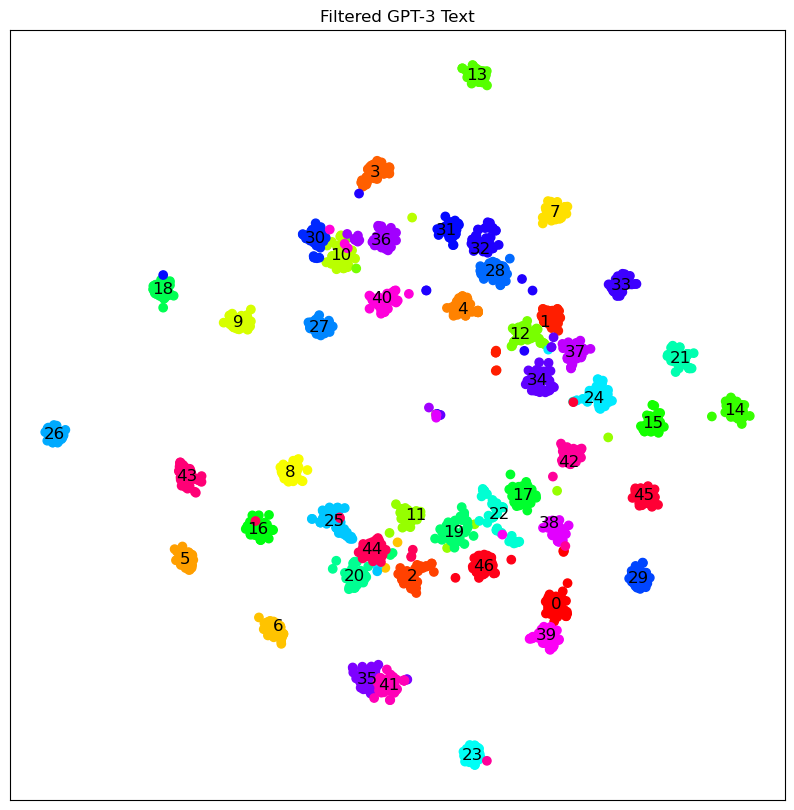

In [37]:
print_top_pairs(np.triu(cls_name_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[cls_name_start_idx:cls_name_end_idx], all_label_ids[cls_name_start_idx:cls_name_end_idx], 'Class Name')
print_top_pairs(np.triu(template_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[template_start_idx:template_end_idx], all_label_ids[template_start_idx:template_end_idx], 'Text Template')
print_top_pairs(np.triu(original_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[original_gpt3_start_idx:original_gpt3_end_idx], all_label_ids[original_gpt3_start_idx:original_gpt3_end_idx], 'Original GPT-3 Text')
print_top_pairs(np.triu(filtered_gpt3_masked_similarity, k=1), 'similarity')
plot_features_2d(transformed_features[filtered_gpt3_start_idx:filtered_gpt3_end_idx], all_label_ids[filtered_gpt3_start_idx:filtered_gpt3_end_idx], 'Filtered GPT-3 Text')